In [1]:
import pandas as pd
from scipy.spatial import distance
import os
# time
import pytz
import datetime
# plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as po
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
# maths and statistics
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from scipy.stats import kstest,ks_2samp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
# process mining
import pm4py
from pm4py.objects.log.importer import xes
from pm4py.objects.conversion.log.versions import to_dataframe
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory
# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
wd = os.getcwd()
"""
get all filenames in working directory
then collect log containing folders
get log files paths and collect logs

"""
logs_paths = []
for file in os.listdir(wd):
    if file.endswith(".xes_"):
        for f in os.listdir(file):
            if f.endswith(".xes"):
                logs_paths.append(os.path.join(wd+'\\'+file, f))
print(logs_paths)

['C:\\PM contest\\Common challenge\\DomesticDeclarations.xes_\\DomesticDeclarations.xes', 'C:\\PM contest\\Common challenge\\InternationalDeclarations.xes_\\InternationalDeclarations.xes', 'C:\\PM contest\\Common challenge\\PermitLog.xes_\\PermitLog.xes', 'C:\\PM contest\\Common challenge\\PrepaidTravelCost.xes_\\PrepaidTravelCost.xes', 'C:\\PM contest\\Common challenge\\RequestForPayment.xes_\\RequestForPayment.xes']


### Таблицы

In [3]:
domestic_declarations = xes_importer.apply(wd + '\DomesticDeclarations.xes_\DomesticDeclarations.xes')

In [4]:
int_declarations = xes_importer.apply(wd + '\InternationalDeclarations.xes_\InternationalDeclarations.xes')

In [5]:
permit_log = xes_importer.apply(wd + '\PermitLog.xes_\PermitLog.xes')

In [6]:
prepaid_travel_cost = xes_importer.apply(wd + '\PrepaidTravelCost.xes_\PrepaidTravelCost.xes')

In [7]:
request_for_payment = xes_importer.apply(wd + '\RequestForPayment.xes_\RequestForPayment.xes')

In [8]:
permit_log = pd.read_csv('C://PM contest//Common challenge//PermitLog.xes_//compact_PermitLog.csv')
permit_log['time:timestamp']=permit_log['time:timestamp'].map(lambda x: datetime.datetime.fromisoformat(x))

In [9]:
domestic_declarations = to_dataframe.apply(domestic_declarations)
int_declarations = to_dataframe.apply(int_declarations)
permit_log = to_dataframe.apply(permit_log)
prepaid_travel_cost = to_dataframe.apply(prepaid_travel_cost)
request_for_payment = to_dataframe.apply(request_for_payment)

In [10]:
dfs_list = [domestic_declarations,int_declarations,permit_log,prepaid_travel_cost,request_for_payment]

### Timestamp with timezone --> timestamp unified

In [11]:
"""
converts to UTC-format for unified timestamp format
:param: df - selected table
:param: time_column - column with the following time format %Y-%m-%d HH:MM:SS+0X:00
:return: converted to UTC-format timestmp without timezone
"""

def to_utc(df, time_column):
    utc = pytz.timezone('UTC')
    df[time_column] = df[time_column].map(lambda x: x.astimezone(utc).replace(tzinfo=None))
    return df

In [12]:
for df in dfs_list:
    df = to_utc(df, 'time:timestamp')

### 3. Is there are difference in throughput between national and international trips?

In [13]:
def time_period_selection(df, start_date, end_date, time_column):
    df = df[(df[time_column]>=start_date)&(df[time_column]<=end_date)]
    return df

In [264]:
td_17 = time_period_selection(domestic_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
td_18 = time_period_selection(domestic_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

ti_17 = time_period_selection(int_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
ti_18 = time_period_selection(int_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

rp_17 = time_period_selection(request_for_payment,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
rp_18 = time_period_selection(request_for_payment,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

pl_17 = time_period_selection(permit_log,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
pl_18 = time_period_selection(permit_log,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')


ptc_17 = time_period_selection(prepaid_travel_cost,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
ptc_18 = time_period_selection(prepaid_travel_cost,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

In [268]:
dd_17 = domestic_declarations[domestic_declarations['case:id'].isin(set(td_17['case:id']))].reset_index(drop=True)
dd_18 = domestic_declarations[domestic_declarations['case:id'].isin(set(td_18['case:id']))].reset_index(drop=True)

id_17 = int_declarations[int_declarations['case:id'].isin(set(ti_17['case:id']))].reset_index(drop=True)
id_18 = int_declarations[int_declarations['case:id'].isin(set(ti_18['case:id']))].reset_index(drop=True)

rp_17 = request_for_payment[request_for_payment['case:Rfp_id'].isin(set(rp_17['case:Rfp_id']))].reset_index(drop=True)
rp_18 = request_for_payment[request_for_payment['case:Rfp_id'].isin(set(rp_18['case:Rfp_id']))].reset_index(drop=True)

pl_17 = permit_log[permit_log['case:id'].isin(set(pl_17['case:id']))].reset_index(drop=True)
pl_18 = permit_log[permit_log['case:id'].isin(set(pl_18['case:id']))].reset_index(drop=True)

ptc_17 = prepaid_travel_cost[prepaid_travel_cost['case:Rfp_id'].isin(set(ptc_17['case:Rfp_id']))].reset_index(drop=True)
ptc_18 = prepaid_travel_cost[prepaid_travel_cost['case:Rfp_id'].isin(set(ptc_18['case:Rfp_id']))].reset_index(drop=True)

In [270]:
dd_18 = dd_18[~dd_18['case:id'].isin(set(dd_17['case:id']))]
id_18 = id_18[~id_18['case:id'].isin(set(id_17['case:id']))]
ptc_18 = ptc_18[~ptc_18['case:Rfp_id'].isin(set(ptc_17['case:Rfp_id']))]
rpf_18 = rp_18[~rp_18['case:Rfp_id'].isin(set(rp_17['case:Rfp_id']))]
pl_18 = pl_18[~pl_18['case:id'].isin(set(pl_17['case:id']))]

In [271]:
len(set(dd_17['case:id'])), len(set(dd_18['case:id']))

(2240, 8260)

In [272]:
len(set(id_17['case:id'])), len(set(id_18['case:id']))

(1552, 4897)

### Кластеризация процессов 

> Label encoder'ом перевела в цифры все состояния, которые есть в столбце case:concept, полученные значения перевела в стобцы вида col_(порядковый номер признака) и дальше по каждой декларации проставляла 0 - если нет этого этапа, 1 - если есть. Потом я взяла эти признаки как отдельные пространства и спроецировала на плоскость. Можешь попробовать РСА, но я попробовала - никаких инсайтов. Отлично работает TSNE. Дальше, когда мы спроецировали на плоскость, можем проводить кластерный анализ: DBSCAN, KMeans, Hierarchical Clustering, Spectral и прочие.
https://scikit-learn.org/stable/modules/clustering.html
Я бы пофайнтюнила DBSCAN, KMeans

In [273]:
def tsne_projecting(d_frame, concept_name_column, case_id_column):
    le = preprocessing.LabelEncoder()
    le.fit(list(set(d_frame[concept_name_column])))
    outlier_label = len(list(set(d_frame[concept_name_column])))+2
    d_frame['concept:name:label']=le.transform(d_frame[concept_name_column].to_list())
    vectors_dd = pd.DataFrame(d_frame.groupby([case_id_column])['concept:name:label'].apply(lambda x: list(x)))
    vectors_dd['length'] = vectors_dd['concept:name:label'].map(lambda x: len(x))
    max_ = vectors_dd['length'].max()
    labels_set = set(d_frame['concept:name:label'])
    new_vecs = []
    for i in range(len(vectors_dd)):
        small_ = []
        for j in labels_set:
            if j in vectors_dd['concept:name:label'].iloc[i]:
                small_.append(1)
            else:
                small_.append(0)
        new_vecs.append(small_)
    vectors_dd['new_vecs'] = new_vecs
    column_names = []
    for i in range(len(labels_set)):
        name = 'col_'+str(i)
        column_names.append(name)
    for i in column_names:
        num = int(i.split('_')[-1])
        vectors_dd[i] = None
        list_ = []
        for j in range(len(vectors_dd)):
            list_.append(vectors_dd['new_vecs'].iloc[j][num])
        vectors_dd[i]=list_
    # clustering
    vectors_dd = vectors_dd.reset_index()
    X = vectors_dd[column_names].values
    tsne = TSNE(random_state=17)
    tsne_representation = tsne.fit_transform(X)
    return X, tsne_representation, vectors_dd

In [274]:
#X_dd_18, tsne_representation_dd_18, vectors_dd_18 = tsne_projecting(dd_18, 'concept:name', 'case:id')
#X_id_18, tsne_representation_id_18, vectors_id_18 = tsne_projecting(id_18, 'concept:name', 'case:id')
#X_rp_18, tsne_representation_rp_18, vectors_rp_18 = tsne_projecting(rpf_18, 'concept:name', 'case:Rfp_id')
X_ptc_18, tsne_representation_ptc_18, vectors_ptc_18 = tsne_projecting(ptc_18, 'concept:name', 'case:Rfp_id')
#X_pl_18, tsne_representation_pl_18, vectors_pl_18 = tsne_projecting(pl_18, 'concept:name', 'case:id')

In [275]:
#tdf_dd_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_dd_18['tsne_1'] = tsne_representation_dd_18[:,0]
#tdf_dd_18['tsne_2'] = tsne_representation_dd_18[:,1]

#tdf_id_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_id_18['tsne_1'] = tsne_representation_id_18[:,0]
#tdf_id_18['tsne_2'] = tsne_representation_id_18[:,1]

tdf_ptc_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
tdf_ptc_18['tsne_1'] = tsne_representation_ptc_18[:,0]
tdf_ptc_18['tsne_2'] = tsne_representation_ptc_18[:,1]

#tdf_rp_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_rp_18['tsne_1'] = tsne_representation_rp_18[:,0]
#tdf_rp_18['tsne_2'] = tsne_representation_rp_18[:,1]

#tdf_pl_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_pl_18['tsne_1'] = tsne_representation_pl_18[:,0]
#tdf_pl_18['tsne_2'] = tsne_representation_pl_18[:,1]

### K-means

In [276]:
from sklearn.cluster import KMeans

In [277]:
disortions = []
K = range(1,10)
for k in K:
    kmean_model = KMeans(n_clusters = k)
    kmean_model.fit(tdf_ptc_18[['tsne_1','tsne_2']].values)
    disortions.append(kmean_model.inertia_)

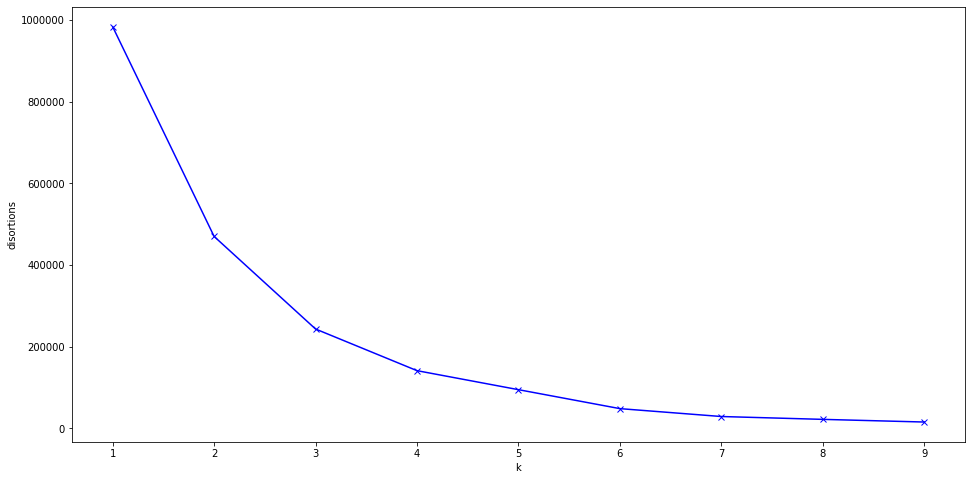

In [278]:
plt.figure(figsize=(16,8))
plt.plot(K, disortions, 'bx-')
plt.xlabel('k'),
plt.ylabel('disortions')
plt.show()

In [279]:
len(tdf_ptc_18[['tsne_1', 'tsne_2']])

1776

In [403]:
#kmean_model = KMeans(n_clusters = 4)
#kmean_model.fit(tdf_dd_18)
#tdf_dd_18['KMeans_label'] = kmean_model.labels_

kmean_model = KMeans(n_clusters = 7)
kmean_model.fit(tdf_ptc_18[['tsne_1', 'tsne_2']].values)
tdf_ptc_18['KMeans_label'] = kmean_model.labels_

In [404]:
kmean_model.cluster_centers_

array([[-15.55135  ,  -8.535147 ],
       [ 11.074707 ,   1.5472759],
       [  5.0924015,  30.535318 ],
       [ 34.615116 ,  -7.528297 ],
       [-17.247059 ,  18.40059  ],
       [  9.134719 , -23.06672  ],
       [ 33.852528 ,   8.206322 ]], dtype=float32)

### Для поиска оптимального eps DBSCAN

In [405]:
def eps_search(n, X):
    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    return distances

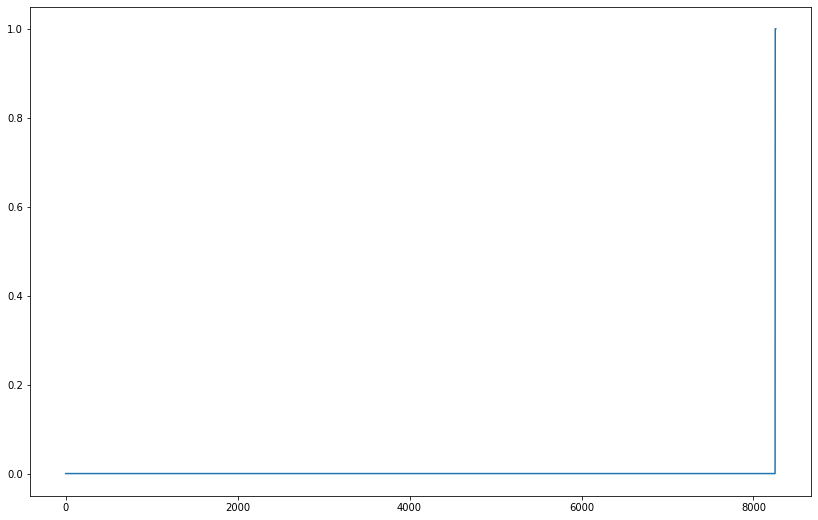

In [406]:
d = eps_search(2, X_dd_18)

### DBSCAN

> В DBSCAN мы в eps очерчиваем радиус окружности, а в min samples указваыем количество соседей в окружности, после чего мы такой кейс посчитаем кластером.


In [407]:
# Для домашних деклараций я фиксировала эти
#cluster = DBSCAN(eps = 0.5, min_samples = 80).fit(X_dd_18)
#tdf_dd_18['DBSCAN_label'] = cluster.labels_

# международные
cluster = DBSCAN(eps = 0.01, min_samples = 80).fit(X_ptc_18)
tdf_ptc_18['DBSCAN_label'] = cluster.labels_

In [408]:
fig = px.scatter(tdf_ptc_18, x = tsne_representation_ptc_18[:, 0], y = tsne_representation_ptc_18[:, 1],
                color = tdf_ptc_18['KMeans_label'].to_list(),
                height = 800, width = 900,
                title = "KMEans prepayed travel costs")
fig.update_layout(font_size =15)
#fig.show()

In [290]:
tdf_ptc_18['case:id'] = vectors_ptc_18['case:Rfp_id']

In [291]:
tdf_ptc_18.head()

,tsne_1,tsne_2,KMeans_label,DBSCAN_label,case:id
0,-15.258638,-8.607328,1,0,request for payment 1000
1,-22.309946,20.481384,2,-1,request for payment 10043
2,10.478837,1.566347,0,1,request for payment 10103
3,-13.989343,-10.047477,1,0,request for payment 10231
4,-15.643131,-8.504961,1,0,request for payment 10234


In [409]:
tdf_ptc_18['KMeans_label'].value_counts()

0    658
1    389
2    190
3    175
6    140
4    116
5    108
Name: KMeans_label, dtype: int64

In [420]:
third_cluster = prepaid_travel_cost[prepaid_travel_cost['case:concept:name'].isin(
    set(tdf_ptc_18[(tdf_ptc_18['DBSCAN_label']==6)]['case:id']))].reset_index(drop=True).to_excel('sixth_kmeans.xlsx')

In [414]:
tdf_ptc_18['DBSCAN_label'].value_counts()

 0    633
 1    368
-1    345
 3    140
 2    113
 4     93
 5     84
Name: DBSCAN_label, dtype: int64

In [395]:
third_cluster.columns

Index(['id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
       'case:Rfp_id', 'case:Permit travel permit number', 'case:Task',
       'case:OrganizationalEntity', 'case:RequestedAmount', 'case:Activity',
       'case:Permit TaskNumber', 'case:Permit BudgetNumber',
       'case:Permit ProjectNumber', 'case:Project', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:Permit RequestedBudget',
       'case:Cost Type', 'case:Permit id', 'case:Permit ActivityNumber',
       'case:RfpNumber'],
      dtype='object')

In [396]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [397]:
# прямой граф
log = conversion_factory.apply(third_cluster)
dfg = dfg_factory.apply(log)
dfg = dfg_factory.apply(log)
gviz = dfg_vis_factory.apply(dfg, log=log)
#gviz.render("first")

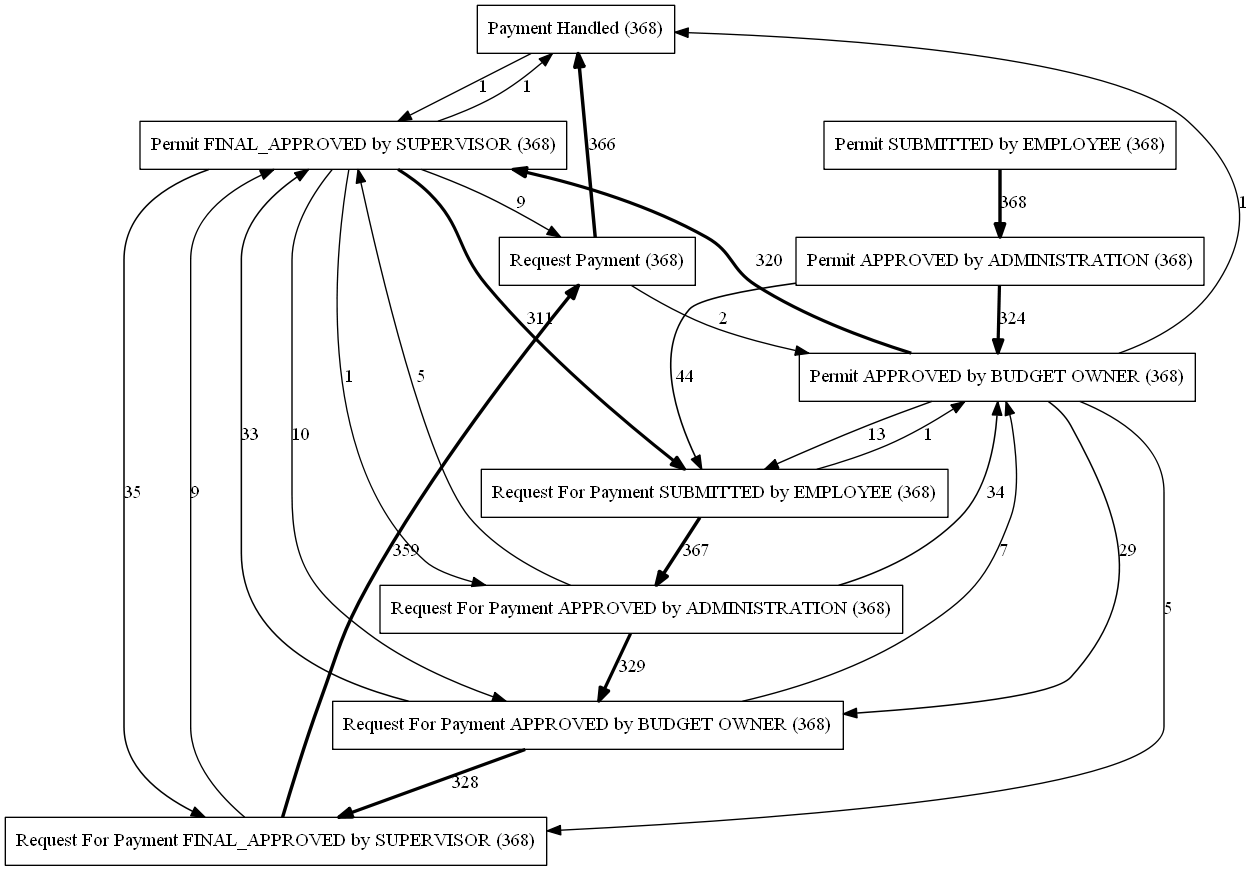

In [398]:
dfg_vis_factory.view(gviz)

In [399]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner

In [400]:
heu_net = heuristics_miner.apply_heu(log, parameters={"min_act_count":10})
                                                      #"dfg_pre_cleaning_noise_thresh":0.05})

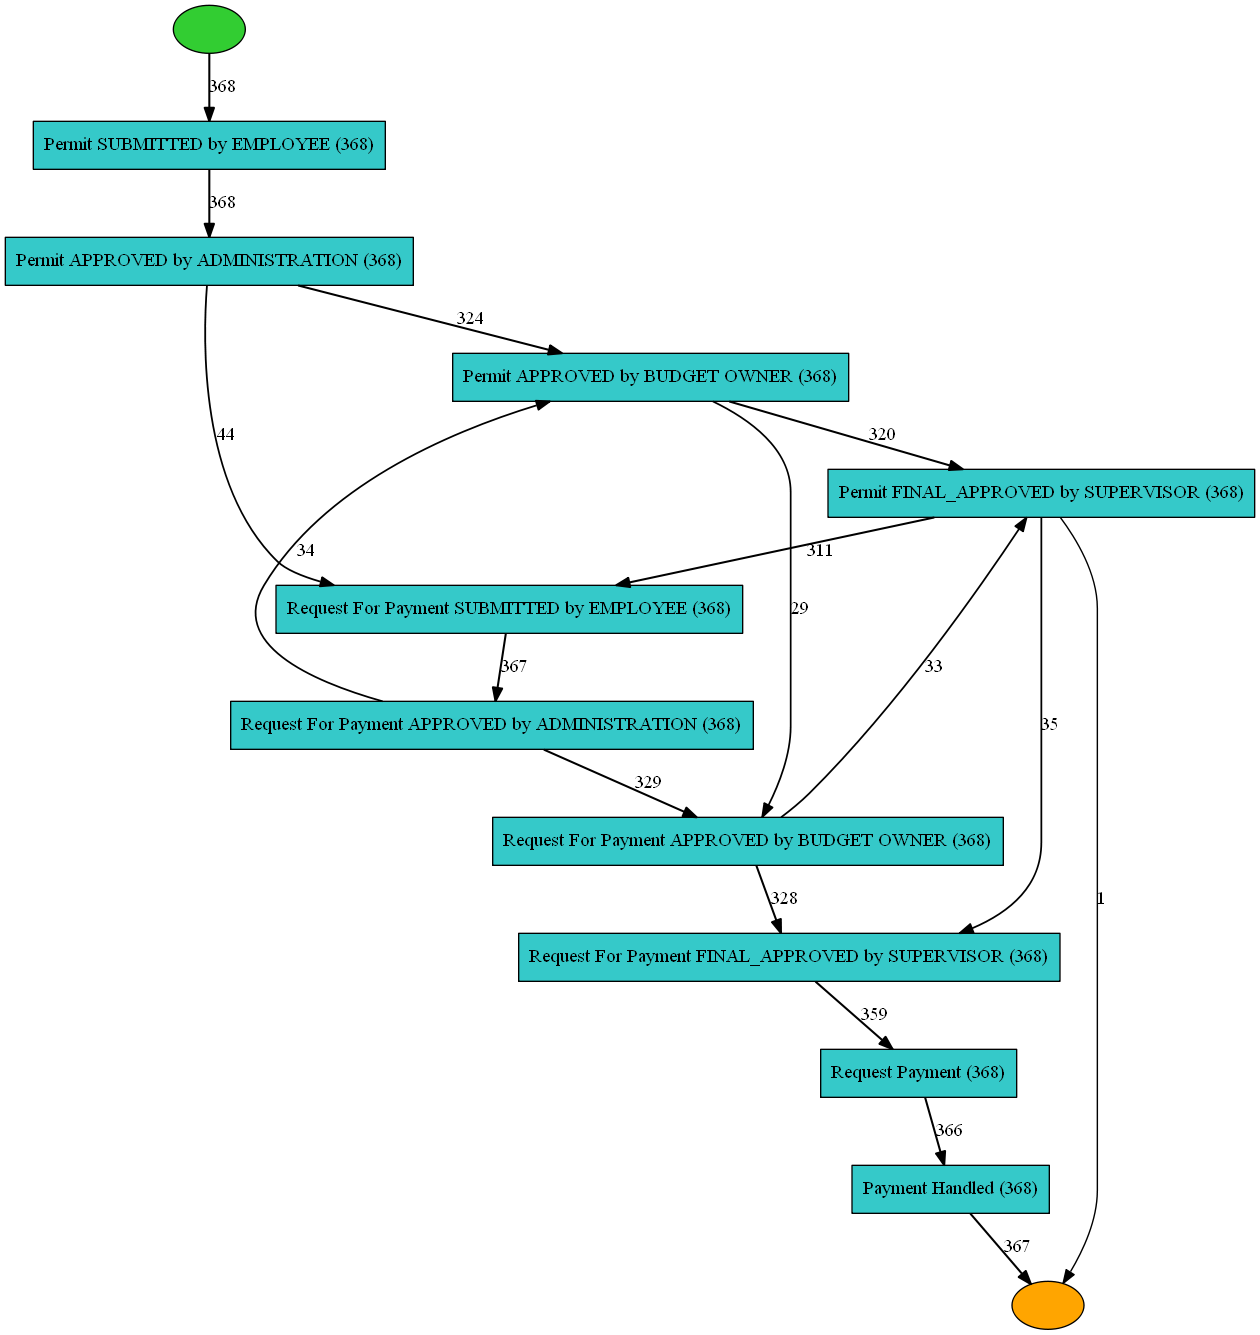

In [401]:
from pm4py.visualization.heuristics_net import factory as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)

### Hierarchical Clustering

In [ ]:
import scipy
from scipy.spatial.distance import pdist

In [ ]:
X = scipy.spatial.distance.squareform(pdist(tsne_representation_id_18, 'euclidean'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='single')
cluster.fit(X)

In [ ]:
len(cluster.labels_)

In [ ]:
tdf_id_18['Agglomerative_label'] = cluster.labels_

In [ ]:
tdf_id_18['Agglomerative_label'].value_counts()

In [ ]:
fig = px.scatter(tdf_id_18, x = tsne_representation_id_18[:, 0], y = tsne_representation_id_18[:, 1],
                color = tdf_id_18['Agglomerative_label'].to_list(),
                height = 800, width = 800,
                title = "Agglomerative international")
fig.update_layout(font_size =15)
#fig.show()

In [ ]:
third_cluster = int_declarations[int_declarations['case:concept:name'].isin(
    set(tdf_id_18[(tdf_id_18['Agglomerative_label']==9)]['case:id']))].reset_index(drop=True)

In [ ]:
# прямой граф
log = conversion_factory.apply(third_cluster)
dfg = dfg_factory.apply(log)
dfg = dfg_factory.apply(log)
gviz = dfg_vis_factory.apply(dfg, log=log)
#gviz.render("first")

In [ ]:
heu_net = heuristics_miner.apply_heu(log, parameters={"min_act_count":20,
                                                      "dfg_pre_cleaning_noise_thresh":0.20})

gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)


#### Distribution of declarations on projects

In [37]:
declarations_on_projects = pd.DataFrame(id_18.groupby(['case:Permit ProjectNumber'])['case:id'].nunique())

In [38]:
pl_18.columns

Index(['Unnamed: 0', 'id', 'org:resource', 'concept:name', 'time:timestamp',
       'org:role', 'case:TotalDeclared', 'case:concept:name', 'case:Overspent',
       'case:travel permit number', 'case:id', 'case:RequestedBudget',
       'case:BudgetNumber', 'case:OverspentAmount', 'case:dec_id',
       'case:DeclarationNumber', 'case:RequestedAmount', 'case:Activity',
       'case:RfpNumber', 'case:OrganizationalEntity', 'case:Rfp_id',
       'case:CostType', 'case:Task', 'case:Project', 'concept:name:label'],
      dtype='object')

In [39]:
declarations_on_projects = pd.DataFrame(pl_18.groupby(['case:Project'])['case:id'].nunique())

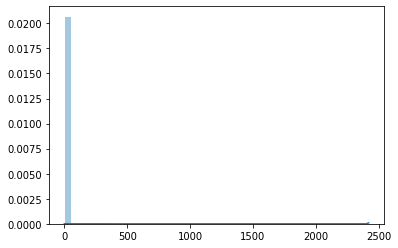

In [40]:
import seaborn as sns
sns.distplot(declarations_on_projects['case:id'].to_list())

In [41]:
declarations_on_projects.sort_values(['case:id'], ascending = False)

,case:id
case:Project,
UNKNOWN,2418
project 3442,36
project 1623,29
project 981,28
project 1185,28
...,...
project 54032,1
project 2734,1
project 36951,1


In [42]:
#clear = declarations_on_projects[(declarations_on_projects['case:id']!=1858)&(declarations_on_projects['case:id']!=282)]
clear = declarations_on_projects[(declarations_on_projects['case:id']!=2418)]

In [43]:
clear.sort_values(['case:id'], ascending = True)

,case:id
case:Project,
project 54698,1
project 31793,1
project 31752,1
project 59677,1
project 59648,1
...,...
project 1115,27
project 981,28
project 1185,28


In [44]:
pl.rcParams['figure.figsize'] = (14, 9)

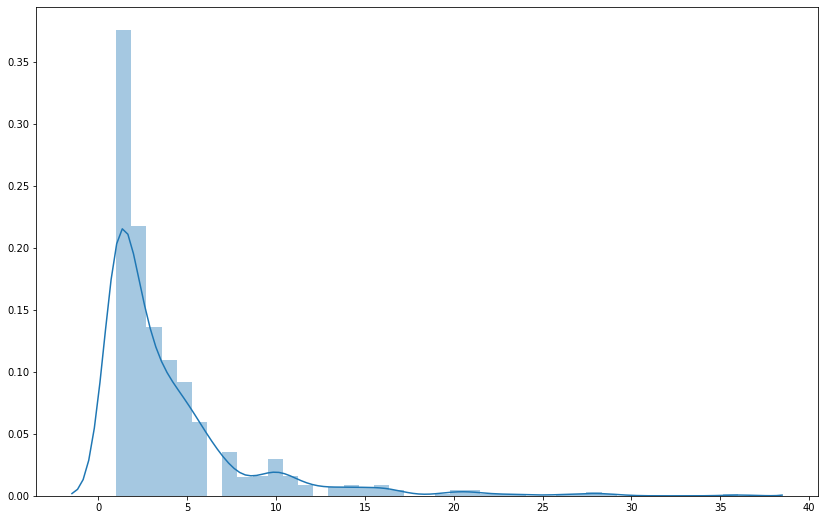

In [45]:
sns.distplot(clear['case:id'].to_list())

### Double payments

In [ ]:
id_18['concept:name'].value_counts()

In [ ]:
double_payments = pd.DataFrame(id_18[id_18['concept:name']=='Payment Handled'].groupby(['case:id'])['concept:name'].apply(lambda x: list(x)))

In [ ]:
double_payments['concept:name_length'] = double_payments['concept:name'].map(lambda x: len(x))

In [ ]:
double_payments[double_payments['concept:name_length']>1]

In [ ]:
pl_18.head()

In [ ]:
int_declarations.columns

In [ ]:
id_18_p = id_18[id_18['case:Permit ProjectNumber']!='UNKNOWN']

In [ ]:
id_18_p['case:permit pn'] = id_18_p['case:Permit ProjectNumber'].map(lambda x: int(x.split()[-1]))

In [ ]:
pl_18_p = pl_18[pl_18['case:Project']!='UNKNOWN']
pl_18_p['case:permit pn'] = pl_18_p['case:Project'].map(lambda x: int(x.split()[-1]))

In [ ]:
test = pd.merge(pl_18_p, id_18_p, how = 'inner', on = ['case:permit pn'])

In [ ]:
test['case:permit pn'].value_counts()

In [ ]:
test[test['case:permit pn']==1623]['case:concept:name_x'].value_counts()